# Model 1

In [ ]:
# =====================
# AutoEncoder-based Unsupervised Anomaly Detection
# =====================
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import cv2
import glob
import os
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
import seaborn as sns

In [ ]:
# 1. Load good training images from train/good
from google.colab import drive
drive.mount('/content/drive')
train_paths = sorted(glob.glob('/content/drive/MyDrive/Colab_Notebooks/DL_HW3/bottle/train/good/*.png'))
x_train = []
for path in tqdm(train_paths):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x_train.append(img)


Mounted at /content/drive


  0%|          | 0/209 [00:00<?, ?it/s]

In [ ]:
print(len(train_paths))

209


In [ ]:
# 2. Load test images (good + defect)
test_good_paths = sorted(glob.glob('/content/drive/MyDrive/Colab_Notebooks/DL_HW3/bottle/test/good/*.png'))
test_defect_paths = sorted([p for p in glob.glob('/content/drive/MyDrive/Colab_Notebooks/DL_HW3/bottle/test/*/*.png') if 'good' not in p])

x_test, y_test = [], []
for path in tqdm(test_good_paths):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x_test.append(img)
    y_test.append(0)
for path in tqdm(test_defect_paths):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x_test.append(img)
    y_test.append(1)

# Transform: Resize + Normalize + ToTensor
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

class ImageDataset(Dataset):
    def __init__(self, imgs, transform):
        self.imgs = imgs
        self.transform = transform
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, idx):
        img = Image.fromarray(self.imgs[idx].astype(np.uint8))
        img = self.transform(img)
        return img

train_dataset = ImageDataset(x_train, transform)
test_dataset = ImageDataset(x_test, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

In [ ]:
# 3. Define Improved AutoEncoder (UNet-style)
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = nn.Sequential(nn.Conv2d(3, 32, 3, stride=2, padding=1), nn.ReLU())     # 64x64
        self.enc2 = nn.Sequential(nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU())    # 32x32
        self.enc3 = nn.Sequential(nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.ReLU())   # 16x16

        self.dec1 = nn.Sequential(nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), nn.ReLU())  # 32x32
        self.dec2 = nn.Sequential(nn.ConvTranspose2d(128, 32, 4, stride=2, padding=1), nn.ReLU())  # 64x64
        self.dec3 = nn.Sequential(nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1), nn.Sigmoid()) # 128x128

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)

        d1 = self.dec1(e3)
        d1_cat = torch.cat([d1, e2], dim=1)  # skip connection
        d2 = self.dec2(d1_cat)
        d2_cat = torch.cat([d2, e1], dim=1)  # skip connection
        out = self.dec3(d2_cat)
        return out

In [ ]:
# 4. Training AutoEncoder(使用MSE作為Loss Function)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoEncoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion1 = nn.MSELoss()


for epoch in range(20):
    model.train()
    total_loss = 0
    for x in train_loader:
        x = x.to(device)
        optimizer.zero_grad()
        recon = model(x)
        loss = criterion1(recon, x)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader.dataset):.4f}")

Epoch 1, Loss: 0.1204
Epoch 2, Loss: 0.0879
Epoch 3, Loss: 0.0589
Epoch 4, Loss: 0.0237
Epoch 5, Loss: 0.0159
Epoch 6, Loss: 0.0096
Epoch 7, Loss: 0.0069
Epoch 8, Loss: 0.0050
Epoch 9, Loss: 0.0038
Epoch 10, Loss: 0.0030
Epoch 11, Loss: 0.0025
Epoch 12, Loss: 0.0022
Epoch 13, Loss: 0.0020
Epoch 14, Loss: 0.0018
Epoch 15, Loss: 0.0017
Epoch 16, Loss: 0.0016
Epoch 17, Loss: 0.0015
Epoch 18, Loss: 0.0014
Epoch 19, Loss: 0.0013
Epoch 20, Loss: 0.0013


In [ ]:
# Testing: compute MSE per image
model.eval()
mse_scores = []
with torch.no_grad():
    for x in test_loader:
        x = x.to(device)
        recon = model(x)
        mse = torch.mean((x - recon) ** 2, dim=[1, 2, 3])  # per image MSE
        mse_scores.extend(mse.cpu().numpy())



Confusion Matrix:


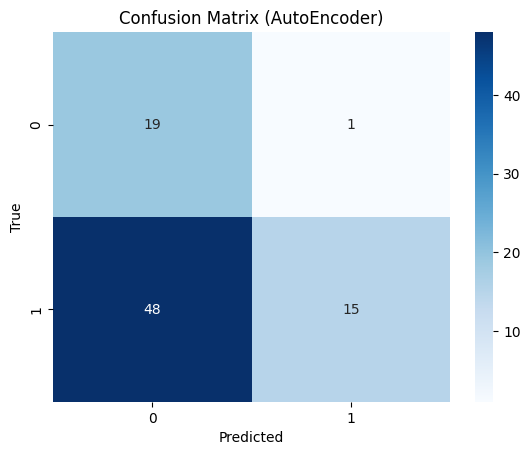


Classification Report:
              precision    recall  f1-score   support

        Good       0.28      0.95      0.44        20
      Defect       0.94      0.24      0.38        63

    accuracy                           0.41        83
   macro avg       0.61      0.59      0.41        83
weighted avg       0.78      0.41      0.39        83


ROC-AUC Score: 0.5008


In [ ]:
# Set threshold and evaluate
threshold = np.percentile(mse_scores[:len(test_good_paths)], 95)  # based on normal data
preds = [1 if s > threshold else 0 for s in mse_scores]

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (AutoEncoder)")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, preds, target_names=['Good', 'Defect']))

auc = roc_auc_score(y_test, mse_scores)
print(f"\nROC-AUC Score: {auc:.4f}")


# Model 2

In [ ]:
from google.colab import drive
import glob
import cv2
import numpy as np
from tqdm.auto import tqdm
import os
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import random
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


In [ ]:
# =====================
# 1. Mount Google Drive and Set Data Path
# =====================

# Mount Drive and set base path
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/Colab_Notebooks/DL_HW3/bottle'

# =====================
# 2. Load train (good) images and sampled defect images
# =====================
train_good_paths = sorted(glob.glob(f"{base_path}/train/good/*.png"))
train_defect_paths = []
sampled_defect_set = set()

# 從每個 defect 類別中抽 N 張當作異常訓練資料
N = 5
all_defect_dirs = sorted([d for d in glob.glob(f"{base_path}/test/*") if 'good' not in d])
for defect_dir in all_defect_dirs:
    paths = sorted(glob.glob(f"{defect_dir}/*.png"))
    sampled = random.sample(paths, min(N, len(paths)))
    train_defect_paths.extend(sampled)
    sampled_defect_set.update(sampled)

x_train, y_train = [], []
for path in tqdm(train_good_paths):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x_train.append(img)
    y_train.append(0)
for path in tqdm(train_defect_paths):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x_train.append(img)
    y_train.append(1)

# =====================
# 3. Load test images (good + all defect excluding used ones)
# =====================
test_good_paths = sorted(glob.glob(f"{base_path}/test/good/*.png"))
test_defect_paths = sorted([p for p in glob.glob(f"{base_path}/test/*/*.png") if 'good' not in p and p not in sampled_defect_set])

x_test, y_test = [], []
for path in tqdm(test_good_paths):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x_test.append(img)
    y_test.append(0)
for path in tqdm(test_defect_paths):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x_test.append(img)
    y_test.append(1)

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

print("✅ x_train:", x_train.shape, "y_train:", y_train.shape)
print("✅ x_test :", x_test.shape,  "y_test :", y_test.shape)
print("y_train counts:", np.bincount(y_train))
print("y_test counts :", np.bincount(y_test))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

✅ x_train: (224, 900, 900, 3) y_train: (224,)
✅ x_test : (68, 900, 900, 3) y_test : (68,)
y_train counts: [209  15]
y_test counts : [20 48]


In [ ]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import torch

# 標準 ImageNet Normalize（搭配 ResNet 使用）
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# 建立 Dataset 類別
class AnomalyDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]

        img = Image.fromarray(img.astype(np.uint8))  # numpy → PIL
        if self.transform:
            img = self.transform(img)

        return img, label


In [ ]:
# 建立 Dataset 實例
train_dataset = AnomalyDataset(x_train, y_train, transform=train_transform)
test_dataset = AnomalyDataset(x_test, y_test, transform=test_transform)

# DataLoader（建議 batch size 可依 GPU 記憶體調整）
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
import torchvision.models as models
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🖥️ Using device:", device)

model = models.resnet18(weights="IMAGENET1K_V1")
model.fc = nn.Linear(model.fc.in_features, 2)  # 二元分類輸出

model = model.to(device)


🖥️ Using device: cuda


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 131MB/s]


In [ ]:
#Try 1: 一般Loss Function
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10

for epoch in range(num_epochs):
    # === Training ===
    model.train()
    total_loss, correct, total = 0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    avg_train_loss = total_loss / total

    # === Evaluation ===
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    avg_val_loss = val_loss / val_total

    print(f"[Epoch {epoch+1}/{num_epochs}] "
          f"Train Loss: {avg_train_loss:.4f} | Acc: {train_acc:.4f} || "
          f"Val Loss: {avg_val_loss:.4f} | Acc: {val_acc:.4f}")


[Epoch 1/10] Train Loss: 0.3161 | Acc: 0.9375 || Val Loss: 1.7058 | Acc: 0.3088
[Epoch 2/10] Train Loss: 0.0567 | Acc: 0.9955 || Val Loss: 1.1595 | Acc: 0.5294
[Epoch 3/10] Train Loss: 0.0199 | Acc: 1.0000 || Val Loss: 0.7062 | Acc: 0.8088
[Epoch 4/10] Train Loss: 0.0116 | Acc: 0.9955 || Val Loss: 0.4184 | Acc: 0.8824
[Epoch 5/10] Train Loss: 0.0037 | Acc: 1.0000 || Val Loss: 0.2790 | Acc: 0.9265
[Epoch 6/10] Train Loss: 0.0218 | Acc: 0.9955 || Val Loss: 0.5081 | Acc: 0.8529
[Epoch 7/10] Train Loss: 0.0158 | Acc: 0.9955 || Val Loss: 0.4582 | Acc: 0.8824
[Epoch 8/10] Train Loss: 0.0045 | Acc: 1.0000 || Val Loss: 0.3862 | Acc: 0.8824
[Epoch 9/10] Train Loss: 0.0069 | Acc: 1.0000 || Val Loss: 0.4217 | Acc: 0.8824
[Epoch 10/10] Train Loss: 0.0053 | Acc: 1.0000 || Val Loss: 0.4635 | Acc: 0.8824


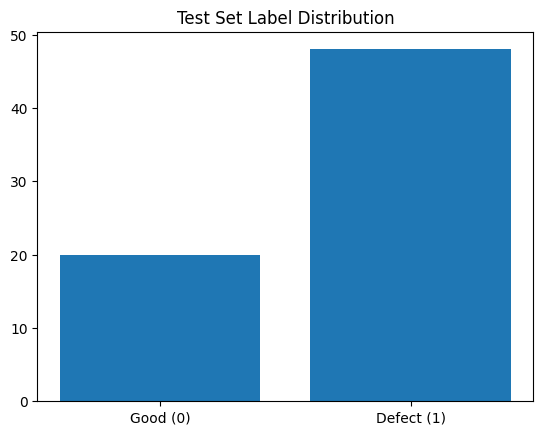

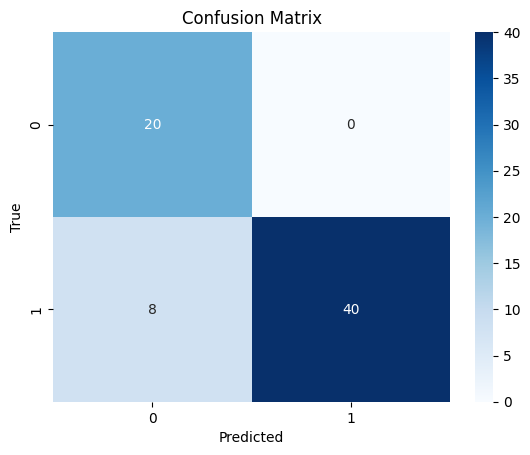


📊 Classification Report:
              precision    recall  f1-score   support

        Good       0.71      1.00      0.83        20
      Defect       1.00      0.83      0.91        48

    accuracy                           0.88        68
   macro avg       0.86      0.92      0.87        68
weighted avg       0.92      0.88      0.89        68



In [ ]:
# 4. 視覺化測試集分布與模型評估

from collections import Counter
from sklearn.metrics import confusion_matrix

# （1）顯示測試集標籤分布
label_counts = Counter(y_test)
plt.bar(['Good (0)', 'Defect (1)'], [label_counts[0], label_counts[1]])
plt.title('Test Set Label Distribution')
plt.show()

# （2）模型推論與混淆矩陣（需有 model 與 test_loader）
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Good', 'Defect']))


# Model 3

In [ ]:
#Try 2: weighted version of standard CrossEntropyLoss
import torch.optim as optim
weights = torch.tensor([1.0, 3.0], dtype=torch.float).to(device)# 使用 class weights：讓異常錯誤被放大懲罰
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10

for epoch in range(num_epochs):
    # === Training ===
    model.train()
    total_loss, correct, total = 0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    avg_train_loss = total_loss / total

    # === Evaluation ===
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    avg_val_loss = val_loss / val_total

    print(f"[Epoch {epoch+1}/{num_epochs}] "
          f"Train Loss: {avg_train_loss:.4f} | Acc: {train_acc:.4f} || "
          f"Val Loss: {avg_val_loss:.4f} | Acc: {val_acc:.4f}")


[Epoch 1/10] Train Loss: 0.0008 | Acc: 1.0000 || Val Loss: 0.3282 | Acc: 0.9265
[Epoch 2/10] Train Loss: 0.0469 | Acc: 0.9911 || Val Loss: 0.4180 | Acc: 0.8971
[Epoch 3/10] Train Loss: 0.0005 | Acc: 1.0000 || Val Loss: 0.3738 | Acc: 0.8971
[Epoch 4/10] Train Loss: 0.0125 | Acc: 0.9955 || Val Loss: 0.1818 | Acc: 0.9412
[Epoch 5/10] Train Loss: 0.0211 | Acc: 0.9955 || Val Loss: 0.2875 | Acc: 0.9118
[Epoch 6/10] Train Loss: 0.0098 | Acc: 1.0000 || Val Loss: 0.3113 | Acc: 0.8971
[Epoch 7/10] Train Loss: 0.0034 | Acc: 1.0000 || Val Loss: 0.3527 | Acc: 0.8824
[Epoch 8/10] Train Loss: 0.0016 | Acc: 1.0000 || Val Loss: 0.3633 | Acc: 0.8824
[Epoch 9/10] Train Loss: 0.0010 | Acc: 1.0000 || Val Loss: 0.3737 | Acc: 0.8824
[Epoch 10/10] Train Loss: 0.0007 | Acc: 1.0000 || Val Loss: 0.3794 | Acc: 0.8824


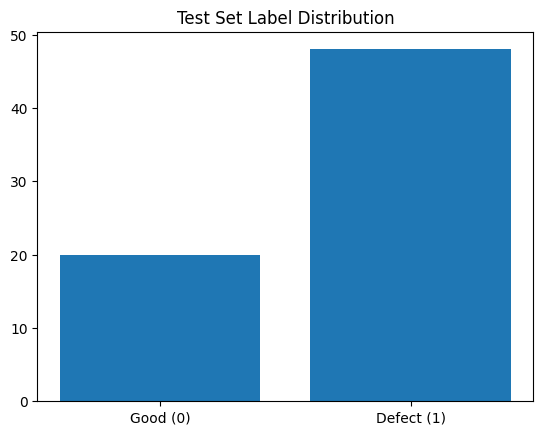

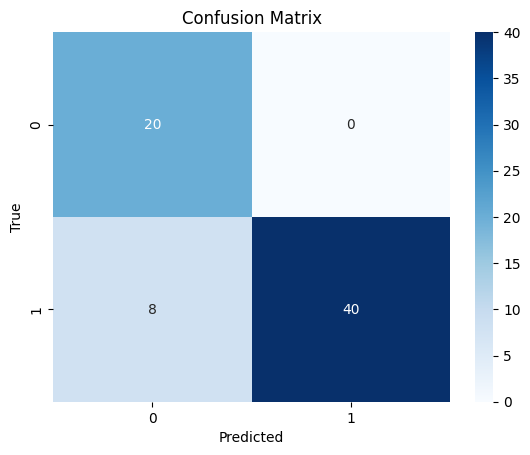


📊 Classification Report:
              precision    recall  f1-score   support

        Good       0.71      1.00      0.83        20
      Defect       1.00      0.83      0.91        48

    accuracy                           0.88        68
   macro avg       0.86      0.92      0.87        68
weighted avg       0.92      0.88      0.89        68



In [ ]:
# 視覺化測試集分布與模型評估

from collections import Counter
from sklearn.metrics import confusion_matrix

# （1）顯示測試集標籤分布
label_counts = Counter(y_test)
plt.bar(['Good (0)', 'Defect (1)'], [label_counts[0], label_counts[1]])
plt.title('Test Set Label Distribution')
plt.show()

# （2）模型推論與混淆矩陣（需有 model 與 test_loader）
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Good', 'Defect']))


# Model 4

In [ ]:
from google.colab import drive
import glob
import cv2
import numpy as np
from tqdm.auto import tqdm
import os
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import random
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


In [ ]:
# =====================
# 1. Mount Google Drive and Set Data Path
# =====================

# Mount Drive and set base path
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/Colab_Notebooks/DL_HW3/bottle'

# =====================
# 2. Load train (good) images and sampled defect images
# =====================
train_good_paths = sorted(glob.glob(f"{base_path}/train/good/*.png"))
train_defect_paths = []
sampled_defect_set = set()

# 從每個 defect 類別中抽 N 張當作異常訓練資料
N = 5
all_defect_dirs = sorted([d for d in glob.glob(f"{base_path}/test/*") if 'good' not in d])
for defect_dir in all_defect_dirs:
    paths = sorted(glob.glob(f"{defect_dir}/*.png"))
    sampled = random.sample(paths, min(N, len(paths)))
    train_defect_paths.extend(sampled)
    sampled_defect_set.update(sampled)

x_train, y_train = [], []
for path in tqdm(train_good_paths):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x_train.append(img)
    y_train.append(0)
for path in tqdm(train_defect_paths):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x_train.append(img)
    y_train.append(1)

# =====================
# 3. Load test images (good + all defect excluding used ones)
# =====================
test_good_paths = sorted(glob.glob(f"{base_path}/test/good/*.png"))
test_defect_paths = sorted([p for p in glob.glob(f"{base_path}/test/*/*.png") if 'good' not in p and p not in sampled_defect_set])

x_test, y_test = [], []
for path in tqdm(test_good_paths):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x_test.append(img)
    y_test.append(0)
for path in tqdm(test_defect_paths):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x_test.append(img)
    y_test.append(1)

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

print("✅ x_train:", x_train.shape, "y_train:", y_train.shape)
print("✅ x_test :", x_test.shape,  "y_test :", y_test.shape)
print("y_train counts:", np.bincount(y_train))
print("y_test counts :", np.bincount(y_test))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


  0%|          | 0/209 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

✅ x_train: (224, 900, 900, 3) y_train: (224,)
✅ x_test : (68, 900, 900, 3) y_test : (68,)
y_train counts: [209  15]
y_test counts : [20 48]


In [ ]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import torch

# 標準 ImageNet Normalize（搭配 ResNet 使用）
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# 建立 Dataset 類別
class AnomalyDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]

        img = Image.fromarray(img.astype(np.uint8))  # numpy → PIL
        if self.transform:
            img = self.transform(img)

        return img, label


In [ ]:
# 建立 Dataset 實例
train_dataset = AnomalyDataset(x_train, y_train, transform=train_transform)
test_dataset = AnomalyDataset(x_test, y_test, transform=test_transform)

# DataLoader（建議 batch size 可依 GPU 記憶體調整）
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
import torchvision.models as models
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🖥️ Using device:", device)

model = models.resnet18(weights="IMAGENET1K_V1")
model.fc = nn.Sequential(
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(128, 2)
)

model = model.to(device)


🖥️ Using device: cuda


In [ ]:
import torch.optim as optim

#criterion = nn.CrossEntropyLoss()
weights = torch.tensor([1.0, 3.0], dtype=torch.float).to(device)# 使用 class weights：讓異常錯誤被放大懲罰
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), weight_decay=1e-5)

num_epochs = 10

for epoch in range(num_epochs):
    # === Training ===
    model.train()
    total_loss, correct, total = 0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    avg_train_loss = total_loss / total

    # === Evaluation ===
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    avg_val_loss = val_loss / val_total

    print(f"[Epoch {epoch+1}/{num_epochs}] "
          f"Train Loss: {avg_train_loss:.4f} | Acc: {train_acc:.4f} || "
          f"Val Loss: {avg_val_loss:.4f} | Acc: {val_acc:.4f}")


[Epoch 1/10] Train Loss: 0.2571 | Acc: 0.9018 || Val Loss: 0.7066 | Acc: 0.7206
[Epoch 2/10] Train Loss: 0.0947 | Acc: 0.9643 || Val Loss: 0.2631 | Acc: 0.8529
[Epoch 3/10] Train Loss: 0.1084 | Acc: 0.9777 || Val Loss: 10.2138 | Acc: 0.7059
[Epoch 4/10] Train Loss: 0.1341 | Acc: 0.9643 || Val Loss: 2.3810 | Acc: 0.7059
[Epoch 5/10] Train Loss: 0.0492 | Acc: 0.9955 || Val Loss: 1.0456 | Acc: 0.8824
[Epoch 6/10] Train Loss: 0.0161 | Acc: 1.0000 || Val Loss: 1.6679 | Acc: 0.7941
[Epoch 7/10] Train Loss: 0.0541 | Acc: 0.9955 || Val Loss: 0.8020 | Acc: 0.8529
[Epoch 8/10] Train Loss: 0.0646 | Acc: 0.9821 || Val Loss: 0.1455 | Acc: 0.8824
[Epoch 9/10] Train Loss: 0.0909 | Acc: 0.9911 || Val Loss: 1.7278 | Acc: 0.7059
[Epoch 10/10] Train Loss: 0.0802 | Acc: 0.9911 || Val Loss: 0.1518 | Acc: 0.9559


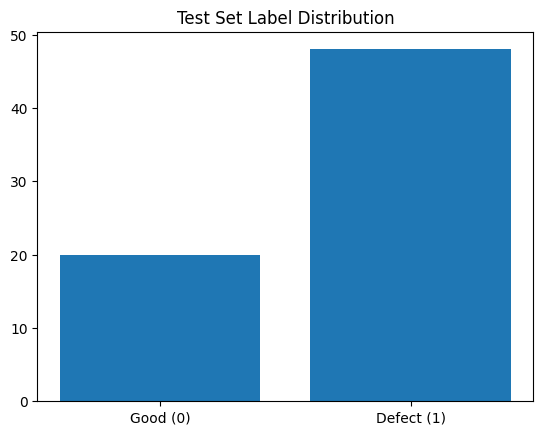

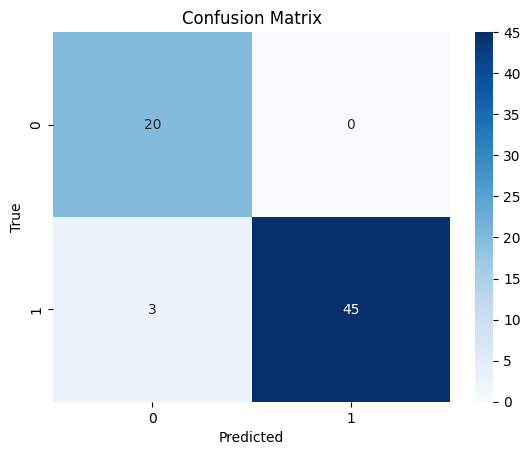


📊 Classification Report:
              precision    recall  f1-score   support

        Good       0.87      1.00      0.93        20
      Defect       1.00      0.94      0.97        48

    accuracy                           0.96        68
   macro avg       0.93      0.97      0.95        68
weighted avg       0.96      0.96      0.96        68



In [ ]:
# =====================
# 4. 視覺化測試集分布與模型評估
# =====================
from collections import Counter
from sklearn.metrics import confusion_matrix

# （1）顯示測試集標籤分布
label_counts = Counter(y_test)
plt.bar(['Good (0)', 'Defect (1)'], [label_counts[0], label_counts[1]])
plt.title('Test Set Label Distribution')
plt.show()

# （2）模型推論與混淆矩陣（需有 model 與 test_loader）
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Good', 'Defect']))
